# VVS-XGBoost

In [5]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/train.csv")

In [2]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, explorative = True)
profile.to_file("Task1ProfileReport.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
import numpy as np

df.drop(columns = ["id", "player_id"], inplace = True)
df = df.dropna(subset = ["is_cheater"])

from xgboost import XGBClassifier, DMatrix, train as xgb_train

X = df.drop("is_cheater", axis = 1)
y = df["is_cheater"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

# native XGBoost
dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [7]:
model = XGBClassifier(
    objective = "multi:softmax",  # multiclass classification
    num_class = 4,                # classes 0-3
    eval_metric = "mlogloss",
    use_label_encoder = False
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Predictions:", y_pred)

Predictions: [1 0 0 ... 0 0 0]


In [8]:
from sklearn.metrics import fbeta_score

f2_macro = fbeta_score(y_test, y_pred, beta = 2, average = "macro")
f2_micro = fbeta_score(y_test, y_pred, beta = 2, average = "micro")
f2_weighted = fbeta_score(y_test, y_pred, beta = 2, average = "weighted")

print(f"F2 Macro: {f2_macro:.4f}")
print(f"F2 Micro: {f2_micro:.4f}")
print(f"F2 Weighted: {f2_weighted:.4f}")

F2 Macro: 0.7628
F2 Micro: 0.8025
F2 Weighted: 0.7991


In [9]:
importance_scores = model.feature_importances_

feat_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": importance_scores
}).sort_values(by = "importance", ascending = False)

feat_importance

,feature,importance
30,crosshair_placement,0.270569
10,reports_received,0.179785
6,account_age_days,0.095229
9,friend_network_size,0.092332
7,level,0.060273
1,headshot_percentage,0.024160
0,kill_death_ratio,0.024070
20,game_sense_score,0.021456
3,accuracy_score,0.017420
19,spray_control_score,0.014654


In [10]:
weak_feature = feat_importance["feature"].tail(15).tolist()

In [11]:
X.drop(columns = weak_feature, inplace = True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify = y
)

dmatrix = DMatrix(X_train, label = y_train, missing = np.nan)

In [12]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

f2_macro = fbeta_score(y_test, y_pred, beta = 2, average = "macro")
f2_micro = fbeta_score(y_test, y_pred, beta = 2, average = "micro")
f2_weighted = fbeta_score(y_test, y_pred, beta = 2, average = "weighted")

print(f"F2 Macro: {f2_macro:.4f}")
print(f"F2 Micro: {f2_micro:.4f}")
print(f"F2 Weighted: {f2_weighted:.4f}")

F2 Macro: 0.7648
F2 Micro: 0.8051
F2 Weighted: 0.8016


In [14]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer
import optuna

f2_macro_scorer = make_scorer(fbeta_score, beta = 2, average = "macro")

def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
        "use_label_encoder": False,
        "objective": "multi:softmax",
        "num_class": 4,
        "eval_metric": "mlogloss",
        "n_jobs": -1,
        "random_state": 42
    }
    
    model = XGBClassifier(**param)
    
    # Stratified 5-fold CV
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    
    # Evaluate using F2 macro
    scores = cross_val_score(model, X, y, cv = cv, scoring = f2_macro_scorer)
    
    return scores.mean()

study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 50)

print("Best trial:")
trial = study.best_trial
print("F2 Macro:", trial.value)
print("Best hyperparameters:", trial.params)

[I 2025-11-28 05:07:17,053] A new study created in memory with name: no-name-c790f730-e715-4ed7-a526-b800cf3d607d
[I 2025-11-28 05:07:27,562] Trial 0 finished with value: 0.7619088803894627 and parameters: {'max_depth': 3, 'learning_rate': 0.2339039476595304, 'n_estimators': 121, 'subsample': 0.7951176246010083, 'colsample_bytree': 0.9565841028848683, 'gamma': 3.900032048251767, 'reg_alpha': 2.1716365248049216, 'reg_lambda': 3.0218781895715665}. Best is trial 0 with value: 0.7619088803894627.
[I 2025-11-28 05:08:07,000] Trial 1 finished with value: 0.7657016745992204 and parameters: {'max_depth': 10, 'learning_rate': 0.04564230328232159, 'n_estimators': 355, 'subsample': 0.5189118362716376, 'colsample_bytree': 0.7585659471346573, 'gamma': 2.5038573625988194, 'reg_alpha': 2.1580702547855934, 'reg_lambda': 1.6395407460369587}. Best is trial 1 with value: 0.7657016745992204.
[I 2025-11-28 05:08:16,869] Trial 2 finished with value: 0.7581223355034685 and parameters: {'max_depth': 8, 'learn

Best trial:
F2 Macro: 0.7670427552297412
Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.09502306779774816, 'n_estimators': 407, 'subsample': 0.5441296871694551, 'colsample_bytree': 0.8023489318611722, 'gamma': 2.236678251235929, 'reg_alpha': 2.8940272572867385, 'reg_lambda': 1.8295240052755743}


In [15]:
model = XGBClassifier(
    objective = "multi:softmax",
    num_class = 4,
    eval_metric = "mlogloss",
    use_label_encoder = False,
    **study.best_params
)

In [16]:
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8023489318611722, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=2.236678251235929, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.09502306779774816,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=407, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [18]:
inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/test.csv")

inference.drop(columns = ["id", "player_id"], inplace = True)
inference.drop(columns = weak_feature, inplace = True)

In [20]:
y_pred = model.predict(inference)
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")
submit["task1"] = y_pred
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")

# StackEnsemble

In [21]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/train.csv")

df.drop(columns = ["id", "player_id"], inplace = True)
df = df.dropna(subset = ["is_cheater"])

X = df.drop(columns = ["is_cheater"])
y = df["is_cheater"].astype(int)

## Feature Selection

In [22]:
from xgboost import XGBClassifier

xgb_for_fi = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False,
    random_state = 42,
    n_jobs = 1
)

xgb_for_fi.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=1, num_parallel_tree=None, random_state=42, ...)

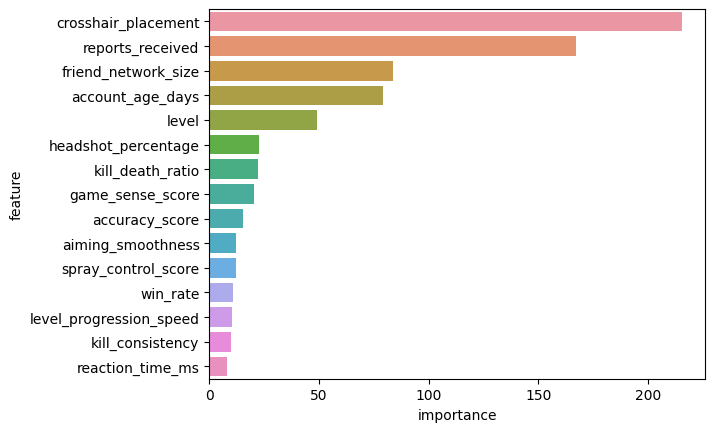

In [23]:
# Extract Feature Importance
booster = xgb_for_fi.get_booster()
fi = booster.get_score(importance_type = "gain")

import matplotlib.pyplot as plt
import seaborn as sns

fi_named = pd.DataFrame(fi.items(), columns = ["feature", "importance"])
Top15 = fi_named.sort_values("importance", ascending = False).head(15)

sns.barplot(data = Top15, y = "feature", x = "importance", orient = "h")
plt.show()

In [24]:
fi_named_sorted = fi_named.sort_values("importance", ascending = False)
fi_named_sorted["cumulative_importance"] = fi_named_sorted["importance"].cumsum() / fi_named_sorted["importance"].sum()
selected_features = fi_named_sorted[fi_named_sorted["cumulative_importance"] <= 0.95]["feature"]

print(f"Selected {len(selected_features)} features out of {len(fi_named)} total features")
X_selected = X[selected_features].copy()

Selected 24 features out of 31 total features


## Modeling

In [25]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score, make_scorer

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

estimators = [
    ("XGBoost", XGBClassifier(
        objective = "binary:logistic",
        eval_metric = "logloss",
        use_label_encoder = False,
        random_state = 42,
        n_jobs = 1
    )),
    ("LightGBM", LGBMClassifier(
        objective = "binary",
        metric = "binary_logloss",
        random_state = 42,
        n_jobs = 1
    )),
    ("CatBoost", CatBoostClassifier(
        loss_function = "Logloss",
        eval_metric = "Logloss",
        verbose = 0,
        random_state = 42,
        thread_count = 1
    ))
]

blender = LogisticRegression(solver = "saga", max_iter = 2000, random_state = 42)

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
fbeta_scorer = make_scorer(fbeta_score, beta = 2, average = "binary")
scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
print(f"Stacking (XGB+LGBM+Cat -> LR): mean F2 = {scores.mean():.4f}  (+/- {scores.std():.4f})")

Stacking (XGB+LGBM+Cat -> LR): mean F2 = 0.6442  (+/- 0.0053)


## Hyperparameter

In [ ]:
import optuna

def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 10.0, log = True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),

        "objective": "binary:logistic",
        "use_label_encoder": False,
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_xgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_xgb.optimize(objective_xgb, n_trials = 100)
print("Best XGB params:", study_xgb.best_params, "best f2:", 1 - study_xgb.best_value)

[I 2025-11-28 05:58:41,878] A new study created in memory with name: no-name-51519c00-951a-4ef4-be68-8a2decb926f3
[I 2025-11-28 05:59:10,139] Trial 0 finished with value: 0.35592045924251203 and parameters: {'n_estimators': 218, 'max_depth': 10, 'learning_rate': 0.1618509290001068, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.4936111842654619, 'gamma': 2.5348407664333426e-07, 'reg_alpha': 3.3323645788192616e-08, 'reg_lambda': 0.6245760287469893}. Best is trial 0 with value: 0.35592045924251203.
[I 2025-11-28 05:59:42,557] Trial 1 finished with value: 0.37820963315607636 and parameters: {'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.031456163175583855, 'subsample': 0.9849549260809971, 'colsample_bytree': 0.899465584480253, 'gamma': 8.148018307012941e-07, 'reg_alpha': 4.329370014459266e-07, 'reg_lambda': 4.4734294104626844e-07}. Best is trial 0 with value: 0.35592045924251203.
[I 2025-11-28 05:59:57,609] Trial 2 finished with value: 0.3611971459471951 and parameters: 

In [ ]:
def objective_lgb(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 6, 128),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log = True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log = True),

        "objective": "binary",
        "metric": "binary_logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = LGBMClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_lgb = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_lgb.optimize(objective_lgb, n_trials = 100)
print("Best LGB params:", study_lgb.best_params, "best f2:", 1 - study_lgb.best_value)

In [ ]:
def objective_cat(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3, log = True),
        "depth": trial.suggest_int("depth", 3, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 10.0, log = True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_state": 42,
        "verbose": 0,
        "thread_count" = -1
    }

    model = CatBoostClassifier(**params)
    scores = cross_val_score(model, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_cat = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_cat.optimize(objective_cat, n_trials = 100)
print("Best Cat params:", study_cat.best_params, "best f2:", 1 - study_cat.best_value)

In [ ]:
import copy

def sanitize_xgb_params(p):
    q = copy.deepcopy(p)
    q["objective"] = "binary:logistic"
    q["use_label_encoder"] = False
    q["random_state"] = 42
    q["n_jobs"] = -1
    return q

def sanitize_lgb_params(p):
    q = copy.deepcopy(p)
    q["objective"] = "binary"
    q["metric"] = "binary_logloss"
    q["random_state"] = 42
    q["n_jobs"] = -1
    return q

def sanitize_cat_params(p):
    q = copy.deepcopy(p)
    q["loss_function"] = "Logloss" if "loss_function" not in q else q["loss_function"]
    q["random_state"] = 42
    q["verbose"] = 0
    q["thread_count"] = -1
    return q

# Build the blender objective
def objective_blender(trial):
    C = trial.suggest_float("C", 1e-4, 1e2, log = True)
    penalty = trial.suggest_categorical("penalty", ["l2"])

    # prepare estimator params
    xgb_params = sanitize_xgb_params(study_xgb.best_params)
    lgb_params = sanitize_lgb_params(study_lgb.best_params)
    cat_params = sanitize_cat_params(study_cat.best_params)

    xgb = XGBClassifier(**xgb_params)
    lgb = LGBMClassifier(**lgb_params)
    cat = CatBoostClassifier(**cat_params)

    stack_tuned = StackingClassifier(
        estimators = [
            ("xgb", xgb),
            ("lgbm", lgb),
            ("cat", cat)
        ],
        final_estimator = LogisticRegression(C = C, penalty = penalty, solver = "saga", max_iter = 2000, random_state = 42),
        stack_method = "predict_proba",
        cv = 5,
        n_jobs = 1,
        passthrough = False
    )

    scores = cross_val_score(stack_tuned, X_selected, y, cv = cv, scoring = fbeta_scorer, n_jobs = -1)
    return 1.0 - scores.mean()

study_blender = optuna.create_study(direction = "minimize", sampler = optuna.samplers.TPESampler(seed = 42))
study_blender.optimize(objective_blender, n_trials = 50)
print("Best blender params:", study_blender.best_params, "best f2:", 1 - study_blender.best_value)

In [ ]:
print(study_xgb.best_params)
print(study_lgb.best_params)
print(study_cat.best_params)

print(study_blender.best_params)

## Inference

In [ ]:
params_xgb = {
    'n_estimators': 344,
    'max_depth': 4,
    'learning_rate': 0.11503020156086298,
    'subsample': 0.7537458820696781,
    'colsample_bytree': 0.7065384079240902,
    'gamma': 0.00036390356638230445,
    'reg_alpha': 0.0019023774837369472,
    'reg_lambda': 2.391152011828358e-06
}

params_lgb = {
    'num_leaves': 58,
    'min_child_samples': 77,
    'learning_rate': 0.06735965822531365,
    'n_estimators': 248,
    'subsample': 0.8207244053979785,
    'colsample_bytree': 0.798414648397947,
    'reg_alpha': 1.3636734067052718,
    'reg_lambda': 6.945197479011241
}

params_cat = {
    'iterations': 1492,
    'learning_rate': 0.046198323134297434,
    'depth': 4,
    'l2_leaf_reg': 1.7754789920320172e-07,
    'border_count': 225
}

params_blender = {
    'C': 0.39079671568228835,
    'penalty': 'l2'
}

In [ ]:
import pandas as pd

inference = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/task1/test.csv")
inference.drop(columns = ["id", "player_id"], inplace = True)

# X_test = inference[selected_features].copy()

X_selected = X.copy()
X_test = inference.copy()

In [ ]:
xgb_best = params_xgb
lgb_best = params_lgb
cat_best = params_cat
blender_best = params_blender

xgb_final = XGBClassifier(
    objective = "binary:logistic",
    eval_metric = "logloss",
    use_label_encoder = False,
    random_state = 42,
    n_jobs = 1,
    **xgb_best
)

lgb_final = LGBMClassifier(
    objective = "binary",
    random_state = 42,
    n_jobs = 1,
    **lgb_best
)

cat_final = CatBoostClassifier(
    loss_function = "Logloss",
    eval_metric = "Logloss",
    verbose = 0,
    random_state = 42,
    thread_count = 1,
    **cat_best
)

blender = LogisticRegression(
    solver = "saga",
    max_iter = 5000,
    random_state = 42,
    **blender_best
)

In [ ]:
estimators = [
    ("XGBoost", xgb_final),
    ("LightGBM", lgb_final),
    ("CatBoost", cat_final)
]

stack = StackingClassifier(
    estimators = estimators,
    final_estimator = blender,
    stack_method = "predict_proba",
    cv = 5,
    n_jobs = -1,
    passthrough = False
)

print("Training STACK with best params...")
stack.fit(X_selected, y)
print("DONE retraining with best parameters!")

In [ ]:
probs = stack.predict_proba(X_test)[:, 1]
preds = (probs >= 0.5).astype(int)
print("Predictions ready!")

In [ ]:
submit = pd.read_csv("/kaggle/input/cpe342-karena/public_dataset/sample_submission.csv")

submit["task1"] = preds
submit.to_csv("ThreeTreeStackEnsembleHyperparameter0.5.csv", index = False)